In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
%load_ext line_profiler
%load_ext memory_profiler

## Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

In [8]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

# Multi-factor matrix factorization

## Small example

In [563]:
# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

In [564]:
# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')

In [565]:
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 
# array([[   nan,    nan, 192.14],
#        [   nan, 285.38, 292.98],
#        [226.07, 229.06,    nan],
#        [222.13, 248.42,    nan]])
pd.DataFrame(true_scores).to_csv('viz/multi_true_scores.csv')

### Naive implementation of gradient descent (loop gradient descent over each factor)

1 iteration

In [655]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

In [656]:
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores

In [657]:
baseline

0.3745401188473625

In [658]:
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2197476297753707

In [659]:
alpha = 0.0005
for k in range(n_factors):
    skater_scores_k = skater_scores[:, [k]]
    event_scores_k = event_scores[[k], :]   

    event_gradients_k = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
    skater_gradients_k = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)

    event_scores[[k], :] = event_scores_k - alpha * event_gradients_k
    skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients_k
    
event_scores, skater_scores

(array([[0.82122113, 0.23107951, 1.14796841],
        [0.90530817, 0.31571784, 0.27440279]]),
 array([[1.04320019, 0.74933189],
        [0.74319648, 0.21281884],
        [0.23819621, 0.17623456],
        [0.94684278, 0.71927024]]))

Many iterations

In [671]:
# %%timeit
# Initialize baseline score, and scores of all latent factors
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((4, 2))
event_scores = random_state.random_sample((2, 3))

# Step 2: repeat until convergence
for i in range(1000):
    # a. Calculate residual for every event-skater pair
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    # b. Calculate baseline gradient and update baseline score
    baseline_gradient = np.nansum(residuals)
    baseline = baseline - alpha * baseline_gradient
    
    # c. For each factor k
    for k in range(n_factors):
        # i. Calculate gradients for each factor
        skater_scores_k = skater_scores[:, [k]]
        event_scores_k = event_scores[[k], :]
        
        event_gradients_k = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
        skater_gradients_k = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)
        
        # ii. Update scores for each factor
        event_scores[[k], :] = event_scores_k - alpha * event_gradients_k
        skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients_k
        
    if i in [998, 999]:
        print(f'RMSE: {np.sqrt(np.nanmean(residuals**2))}')

RMSE: 0.002070682021509688
RMSE: 0.002047425469550496


In [672]:
pd.DataFrame(skater_scores, index=skater_names)

,0,1
"Alexander, MAJOROV",9.653103,4.485617
"Javier, FERNANDEZ",14.764506,7.613596
"Misha, GE",9.353478,10.411243
"Takahito, MURA",12.546155,6.994526


### Broadcasted implementation of gradient descent

1 iteration

In [662]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

In [663]:
predicted_scores = skater_scores @ event_scores + baseline
residuals = predicted_scores - true_scores

In [664]:
alpha = 0.0005
baseline_gradient = np.nansum(residuals)
baseline = baseline - alpha * baseline_gradient
baseline

1.2197476297753707

In [665]:
residuals = residuals[np.newaxis, :, :]
event_gradients = np.nansum(residuals *  skater_scores.T[:, :, np.newaxis], axis=1)
skater_gradients = np.nansum(residuals * event_scores[:, np.newaxis, :], axis=2).T

event_scores = event_scores - alpha * event_gradients
skater_scores = skater_scores - alpha * skater_gradients

event_scores, skater_scores

(array([[0.82122113, 0.23107951, 1.14796841],
        [0.90530817, 0.31571784, 0.27440279]]),
 array([[1.04320019, 0.74933189],
        [0.74319648, 0.21281884],
        [0.23819621, 0.17623456],
        [0.94684278, 0.71927024]]))

Many iterations

In [668]:
# Initialize baseline score, and scores of all latent factors
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((4, 2))
event_scores = random_state.random_sample((2, 3))

# Step 2: repeat until convergence
for i in range(1000):
    # a. Calculate residual for every event-skater pair
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    # b. Calculate baseline gradient and update baseline score
    baseline_gradient = np.nansum(residuals)
    baseline = baseline - alpha * baseline_gradient
    
    # c. Calculate gradient and update scores for all factors
    residuals = residuals[np.newaxis, :, :]
    event_gradients = np.nansum(residuals * skater_scores.T[:, :, np.newaxis], axis=1)
    skater_gradients = np.nansum(residuals * event_scores[:, np.newaxis, :], axis=2).T
    
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
        
    if i in [998, 999]:
        print(f'RMSE: {np.sqrt(np.nanmean(residuals**2))}')

RMSE: 0.002070682021509688
RMSE: 0.002047425469550496


In [669]:
pd.DataFrame(skater_scores, index=skater_names)

,0,1
"Alexander, MAJOROV",9.653103,4.485617
"Javier, FERNANDEZ",14.764506,7.613596
"Misha, GE",9.353478,10.411243
"Takahito, MURA",12.546155,6.994526


## Profiling two methods in comparison

### Time profiling

In [674]:
residuals = predicted_scores - true_scores
residuals

array([[            nan,             nan,  6.69081920e-05],
       [            nan,  2.35269804e-04, -1.43158600e-04],
       [-2.80276620e-03,  2.53873160e-03,             nan],
       [ 2.80414637e-03, -2.66447763e-03,             nan]])

In [690]:
def naive_gradient_descent(true_scores, n_iter, n_factors):
    alpha = 0.0005
    
    # Initialize baseline score, and scores of all latent factors
    random_state = np.random.RandomState(seed=42)
    baseline = random_state.random_sample()    
    event_scores = random_state.random_sample((n_factors, true_scores.shape[1]))
    skater_scores = random_state.random_sample((true_scores.shape[0], n_factors))


    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient

        # c. For each factor k
        for k in range(n_factors):
            # i. Calculate gradients for each factor
            skater_scores_k = skater_scores[:, [k]]
            event_scores_k = event_scores[[k], :]

            event_gradients_k = np.nansum(residuals * skater_scores_k, axis=0, keepdims=True)
            skater_gradients_k = np.nansum(residuals * event_scores_k, axis=1, keepdims=True)

            # ii. Update scores for each factor
            event_scores[[k], :] = event_scores_k - alpha * event_gradients_k
            skater_scores[:, [k]] = skater_scores_k - alpha * skater_gradients_k

In [691]:
def broadcast_gradient_descent(true_scores, n_iter, n_factors):
    alpha = 0.0005
    
    # Initialize baseline score, and scores of all latent factors
    random_state = np.random.RandomState(seed=42)
    baseline = random_state.random_sample()
    event_scores = random_state.random_sample((n_factors, true_scores.shape[1]))
    skater_scores = random_state.random_sample((true_scores.shape[0], n_factors))

    # Step 2: repeat until convergence
    for i in range(n_iter):
        # a. Calculate residual for every event-skater pair
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores

        # b. Calculate baseline gradient and update baseline score
        baseline_gradient = np.nansum(residuals)
        baseline = baseline - alpha * baseline_gradient

        # c. Calculate gradient and update scores for all factors
        residuals = residuals[np.newaxis, :, :]
        event_gradients = np.nansum(residuals * skater_scores.T[:, :, np.newaxis], axis=1)
        skater_gradients = np.nansum(residuals * event_scores[:, np.newaxis, :], axis=2).T

        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients

In [695]:
naive_times = []
broadcast_times = []
n_factor_values = 10**np.arange(6)

for k in n_factor_values:
    print(f'Factors: {k}')
    print('Naive: ', end='')
    naive_runtimes = %timeit -o naive_gradient_descent(true_scores, 1, k)
    print('Broadcast: ', end='')
    broadcast_runtimes = %timeit -o broadcast_gradient_descent(true_scores, 1, k)
    
    naive_times.append(np.mean(naive_runtimes.all_runs)*1e6 / naive_runtimes.loops)
    broadcast_times.append(np.mean(broadcast_runtimes.all_runs)*1e6 / broadcast_runtimes.loops)

Factors: 1
Naive: 141 µs ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Broadcast: 89.1 µs ± 3.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 10
Naive: 853 µs ± 113 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Broadcast: 121 µs ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 100
Naive: 7.99 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Broadcast: 208 µs ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Factors: 1000
Naive: 77 ms ± 9.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Broadcast: 802 µs ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Factors: 10000
Naive: 671 ms ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast: 7.66 ms ± 985 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Factors: 100000
Naive: 6.64 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Broadcast: 92.2 ms ± 8.09 ms per loop (m

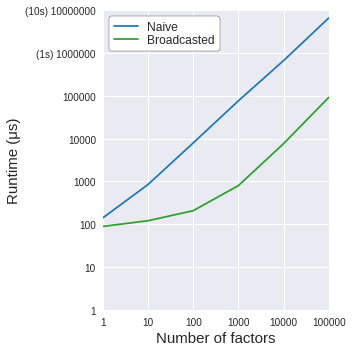

In [697]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_factor_values, naive_times, color='tab:blue', label='Naive')
ax.plot(n_factor_values, broadcast_times, color='tab:green', label='Broadcasted')
ax.set_xscale('log')
ax.set_xticks(n_factor_values)
ax.set_xticklabels(n_factor_values)
ax.set_xlim(1, n_factor_values[-1])
ax.set_xlabel('Number of factors', fontsize=15)

ax.set_yscale('log')
ax.set_yticks(10**np.arange(8))
ax.set_yticklabels(list(10**np.arange(6)) + ['(1s) 1000000', '(10s) 10000000'])
ax.set_ylim(1, 1e7)
ax.set_ylabel('Runtime (μs)', fontsize=15)

ax.legend(**legend_opts)

plt.tight_layout()
plt.show()
fig.savefig('viz/multi_naive_vs_broadcasted.png')

Time profile of broadcasted version

In [762]:
%lprun -f broadcast_gradient_descent broadcast_gradient_descent(true_scores, 1, 100000)

### Memory profiling

In [799]:
np.save('viz/true_scores.npy', true_scores)

# Batch GD using multi factor

### Toy example

In [28]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

pd.DataFrame(skater_scores, index=skater_names).to_csv('viz/skater_scores.csv') # Save for Google sheets
pd.DataFrame(event_scores, columns=event_names).to_csv('viz/event_scores.csv') # Save for Google sheets

# baseline, skater_scores, event_scores

In [29]:
alpha = 0.0005
for i in range(1000):
    # 2a. Calculate gradients
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    baseline_gradient = np.nansum(residuals)
    event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
    skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)
    
    # 2b. Update latent scores using gradients
    baseline = baseline - alpha * baseline_gradient
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    
    if i in [998, 999]:
        print(i, np.sqrt(np.nanmean(residuals**2)))

998 0.002070682021509688
999 0.002047425469550496


In [30]:
pd.DataFrame(skater_scores, index=skater_names).sort_values(by=0, ascending=False)

,0,1
"Javier, FERNANDEZ",14.764506,7.613596
"Takahito, MURA",12.546155,6.994526
"Alexander, MAJOROV",9.653103,4.485617
"Misha, GE",9.353478,10.411243


In [805]:
np.save('viz/true_scores_2017.npy', pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event').values)

### Male skaters in 2017 season

In [810]:
def batch_gd_multi(season_scores, skater_order=None, init_seed=42,
             alpha=0.0005, n_iter=1000, n_factors = 1,
             log_iter=False, log_every=10, additional_iter=range(1, 10),
             return_rmse=False):
    '''
    Run gradient descent on some season scores table (long format)
    Return skater and event scores (along with final RMSE and other intermediate values if needed)'''
    
    # Convert long table to pivot table
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
    # Modify skater position in pivot table (for aesthetic value only)
    if skater_order is not None:
        season_pivot = season_pivot.loc[skater_order]
        
    # Store skater and event names to retrieve later
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)
    
    # Convert pivot table to numpy array
    true_scores = season_pivot.values

    # Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
    random_state = np.random.RandomState(init_seed)
    skater_scores = random_state.random_sample((len(skater_names), n_factors))
    event_scores = random_state.random_sample((n_factors, len(event_names)))
    baseline = random_state.random_sample()   
    
    # Different lists to contain intermediate values if logging is enabled
    skater_scores_log = []
    event_scores_log = []
    baseline_log = []
    rmse_log = []
    residual_log = []
    iter_log = []
    
    # Run gradient descent
    for i in range(n_iter):
        # Calculate predicted scores and residuals
        predicted_scores = skater_scores @ event_scores + baseline
        residuals = predicted_scores - true_scores
        
        # Log intermediate values at certain iterations if logging is enabled
        if log_iter and (i%log_every==0 or (i in additional_iter)):            
            iter_log.append(i)
            skater_scores_log.append(pd.DataFrame(skater_scores, index=skater_names))
            event_scores_log.append(pd.DataFrame(event_scores.T, index=event_names))
            baseline_log.append(baseline)
            residual_log.append(residuals)
            rmse = np.sqrt(np.nanmean(residuals**2))
            rmse_log.append(rmse)
        
        # Calculate parameter gradients
        baseline_gradient = np.nansum(residuals)
        residuals = residuals[np.newaxis, :, :]
        event_gradients = np.nansum(residuals * skater_scores.T[:, :, np.newaxis], axis=1)
        skater_gradients = np.nansum(residuals * event_scores[:, np.newaxis, :], axis=2)
        
        # Update parameters
        baseline = baseline - alpha * baseline_gradient
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients.T
        
        # Print difference in RMSE for last two iterations
        if i == (n_iter-1):
            rmse_old = np.sqrt(np.nanmean(residuals**2))
            residuals = skater_scores @ event_scores + baseline - true_scores
            rmse_new = np.sqrt(np.nanmean(residuals**2))
            print(f'Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    
    # Collect logs together in one list
    log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log]

    # Put event and skater scores back into Series form with names added
    skater_scores = pd.DataFrame(skater_scores, index=skater_names)
    event_scores = pd.DataFrame(event_scores.T, index=event_names)
    
    if log_iter:
        return baseline, event_scores, skater_scores, log
    elif return_rmse:
        return baseline, event_scores, skater_scores, rmse_new
    else:
        return baseline, event_scores, skater_scores

In [811]:
# def batch_gd_multi(season_scores, skater_order=None, init_seed=42,
#              alpha=0.0005, n_iter=1000, n_factors = 1,
#              log_iter=False, log_every=10, additional_iter=range(1, 10),
#              return_rmse=False):
#     '''
#     Run gradient descent on some season scores table (long format)
#     Return skater and event scores (along with final RMSE and other intermediate values if needed)'''
    
#     # Convert long table to pivot table
#     season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    
#     # Modify skater position in pivot table (for aesthetic value only)
#     if skater_order is not None:
#         season_pivot = season_pivot.loc[skater_order]
        
#     # Store skater and event names to retrieve later
#     skater_names = list(season_pivot.index)
#     event_names = list(season_pivot.columns)
    
#     # Convert pivot table to numpy array
#     true_scores = season_pivot.values

#     # Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
#     random_state = np.random.RandomState(init_seed)
#     skater_scores = random_state.random_sample((len(skater_names), n_factors))
#     event_scores = random_state.random_sample((n_factors, len(event_names)))
#     baseline = random_state.random_sample()
    
#     # Different lists to contain intermediate values if logging is enabled
#     skater_scores_log = []
#     event_scores_log = []
#     baseline_log = []
#     rmse_log = []
#     residual_log = []
#     iter_log = []
    
#     # Run gradient descent
#     for i in range(n_iter):
#         # Calculate predicted scores and residuals
#         predicted_scores = skater_scores @ event_scores + baseline
#         residuals = predicted_scores - true_scores
        
#         # Log intermediate values at certain iterations if logging is enabled
#         if log_iter and (i%log_every==0 or (i in additional_iter)):            
#             iter_log.append(i)
#             skater_scores_log.append(pd.DataFrame(skater_scores, index=skater_names))
#             event_scores_log.append(pd.DataFrame(event_scores.T, index=event_names))
#             baseline_log.append(baseline)
#             residual_log.append(residuals)
#             rmse = np.sqrt(np.nanmean(residuals**2))
#             rmse_log.append(rmse)
        
#         # Calculate parameter gradients
#         baseline_gradient = np.nansum(residuals)
#         event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
#         skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)
        
#         # Update parameters
#         baseline = baseline - alpha * baseline_gradient
#         event_scores = event_scores - alpha * event_gradients
#         skater_scores = skater_scores - alpha * skater_gradients
        
#         # Print difference in RMSE for last two iterations
#         if i == (n_iter-1):
#             rmse_old = np.sqrt(np.nanmean(residuals**2))
#             residuals = skater_scores @ event_scores + baseline - true_scores
#             rmse_new = np.sqrt(np.nanmean(residuals**2))
#             print(f'Alpha: {alpha}, Iter: {n_iter}, Last RMSE: {round(rmse_new, 2)}, Delta RMSE: {round(rmse_new - rmse_old, 10)}')
    
#     # Collect logs together in one list
#     log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log]
    
#     # Put event and skater scores back into Series form with names added
#     skater_scores = pd.DataFrame(skater_scores, index=skater_names)
#     event_scores = pd.DataFrame(event_scores.T, index=event_names)
    
#     if log_iter:
#         return baseline, event_scores, skater_scores, log
#     elif return_rmse:
#         return baseline, event_scores, skater_scores, rmse_new
#     else:
#         return baseline, event_scores, skater_scores

In [814]:
# Get skater order from hybrid model example to display in dashboard
example_skater_order = np.load('viz/example_skater_order.npy')
baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, residual_log, rmse_log] = batch_gd_multi(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=151, n_factors=5,
log_iter=True, log_every=5, additional_iter=list(range(16)) + list(range(10, 51, 5)))

Alpha: 0.0005, Iter: 151, Last RMSE: 2.6, Delta RMSE: -0.025845557


In [ ]:
def update(i, fig, ax, axr, verbose=False):
    if verbose:
        print(i, end=' ')
    
    fig.suptitle(f'Iteration {iter_log[i]}\nα = 0.0005', x=0.3, y=0.95, va='bottom', ha='center', fontsize=20)
    residuals = residual_log[i]
    ax.imshow(-residuals, cmap='coolwarm', vmin=-30, vmax=30, aspect='auto') # Neagtive residual: red, positive: blue
    ax.set_yticklabels(skater_scores_log[i].applymap('{:.2f}'.format).apply(lambda x: '  '.join(x), axis=1))
    ax.set_xticklabels(event_scores_log[i].applymap('{:.2f}'.format).apply(lambda x: '\n'.join(x), axis=1),
                       fontsize=10) 
    baseline_text.set_text('{0:.2f}'.format(baseline_log[i]))
    
    if i == 0:
        axr.plot(iter_log[i], rmse_log[i], '.', color='tab:brown', clip_on=False)
    if i >= 1:
        axr.plot(iter_log[i-1:i+1], rmse_log[i-1:i+1], '.-', color='tab:brown', clip_on=False)

001234567891011121314151617181920212223242526272829303132333435363738394041420

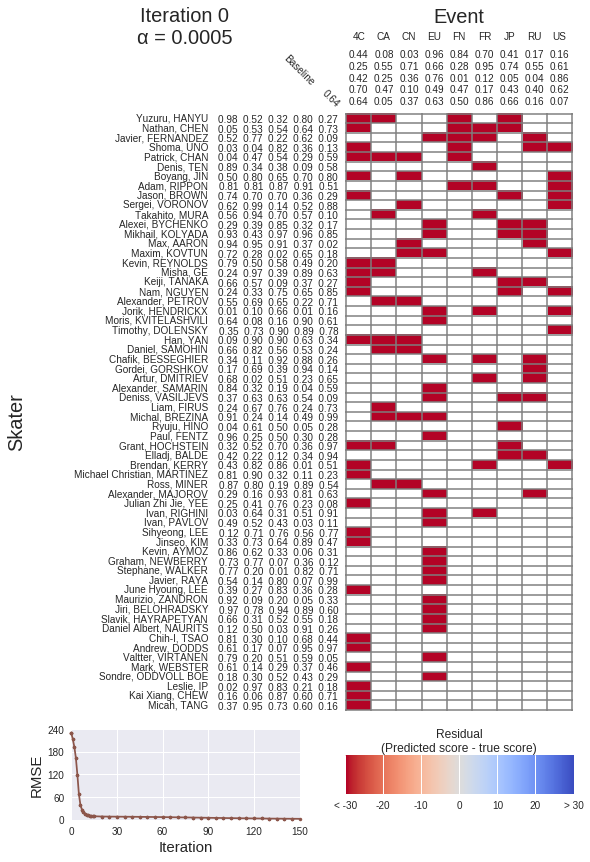

In [929]:
# Set up figure grid
fig = plt.figure(figsize=(9, 13))
grid = plt.GridSpec(20, 2, hspace=1)

# Set up heat map of residuals
ax = fig.add_subplot(grid[:-3, 1])
ax.set_xticks(np.arange(-.5, len(event_names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(skater_names), 1), minor=True)
ax.grid(which='minor', color='tab:gray', ls='-', lw=1.5)
ax.grid(None, which='major')
ax.set_xlim(-0.54, len(event_names)-0.45)
ax.set_xticks(range(len(event_names)))
ax.xaxis.tick_top()
ax.set_ylim(-0.6, len(skater_names)-0.45)
ax.set_yticks(range(len(skater_names)))
ax.set_facecolor('white')


for i, skater in enumerate(skater_names):
    ax.text(x=-6, y=i-0.3, s=skater, ha='right')
for i, event in enumerate(event_names):
    ax.text(x=i, y=len(skater_names)+7, s=event, va='bottom', ha='center')
ax.text(x=-1.7, y=len(skater_names)+2.3, s='Baseline', rotation=-45, va='bottom', ha='right')
baseline_text = ax.text(x=-0.7, y=len(skater_names), s='', rotation=-45, va='bottom', ha='right')

ax.text(x=-14, y=len(skater_names)/2, s='Skater', rotation=90, fontsize=20)
ax.text(x=4, y=len(skater_names)+9, s='Event', fontsize=20, ha='center')

# Set up RMSE plot
axr = fig.add_subplot(grid[-3:, 0])
axr.set_xlim(0, iter_log[-1])
axr.set_xticks(range(0, iter_log[-1]+1, 30))
axr.set_xlabel('Iteration', fontsize=15)
axr.set_ylim(0, 240)
axr.set_yticks(np.arange(0, 241, 60))
axr.set_ylabel('RMSE', fontsize=15)

# Plot colorbar of residual
axc = fig.add_subplot(grid[-3:, 1])
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.arange(cmap.N, -1, -1)) # Plot colorbar from red to blue (not blue to red)
axc.imshow([colors], extent=[-30, 30, 0, 10])
axc.xaxis.set_label_position('top') 
axc.set_xlabel('Residual\n(Predicted score - true score)', fontsize=12)
axc.set_xticklabels(['< -30', '-20', '-10', '0', '10', '20', '> 30'])
axc.set_yticks([])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax, axr, verbose=True), 
                     frames=len(iter_log), interval=500)

anim.save('viz/batch_anim_multi.gif', writer='imagemagick')

# Rank skaters using multiple factors

In [922]:
n_factors = 5
baseline, event_scores, skater_scores, rmse = batch_gd_multi(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=1000, n_factors=n_factors, return_rmse=True)

Alpha: 0.0005, Iter: 1000, Last RMSE: 0.02, Delta RMSE: -7.77431e-05


In [923]:
skater_rankings_by_factor = []
taus_by_factor = []
for i in range(n_factors):
    skater_ranking, world_ranking = return_ranking(skater_scores[i], world_scores)
    skater_rankings_by_factor.append(skater_ranking)
    taus_by_factor.append(calculate_kendall_tau(skater_ranking, world_ranking))

There are 156 concordant_pairs out of 276 pairs
There are 174 concordant_pairs out of 276 pairs
There are 173 concordant_pairs out of 276 pairs
There are 223 concordant_pairs out of 276 pairs
There are 175 concordant_pairs out of 276 pairs


In [866]:
pairwise_kendall_tau = np.zeros((n_factors, n_factors))
for i in range(n_factors):
    for j in range(i, n_factors):
        tau = calculate_kendall_tau(skater_rankings_by_factor[i], skater_rankings_by_factor[j])
        pairwise_kendall_tau[i, j] = tau
        pairwise_kendall_tau[j, i] = tau

There are 276 concordant_pairs out of 276 pairs
There are 130 concordant_pairs out of 276 pairs
There are 105 concordant_pairs out of 276 pairs
There are 139 concordant_pairs out of 276 pairs
There are 155 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs
There are 123 concordant_pairs out of 276 pairs
There are 153 concordant_pairs out of 276 pairs
There are 141 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs
There are 182 concordant_pairs out of 276 pairs
There are 142 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs
There are 178 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs


In [867]:
pairwise_kendall_tau

array([[ 1.        , -0.05797101, -0.23913043,  0.00724638,  0.12318841],
       [-0.05797101,  1.        , -0.10869565,  0.10869565,  0.02173913],
       [-0.23913043, -0.10869565,  1.        ,  0.31884058,  0.02898551],
       [ 0.00724638,  0.10869565,  0.31884058,  1.        ,  0.28985507],
       [ 0.12318841,  0.02173913,  0.02898551,  0.28985507,  1.        ]])

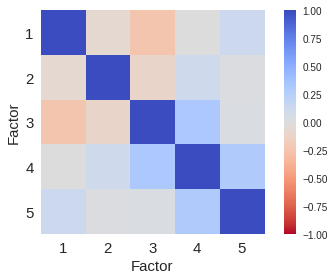

In [910]:
plt.imshow(pairwise_kendall_tau, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(n_factors), range(1, n_factors+1), fontsize=15)
plt.xlabel('Factor', fontsize=15)
plt.yticks(range(n_factors), range(1, n_factors+1), fontsize=15)
plt.ylabel('Factor', fontsize=15)
plt.grid(None)

plt.tight_layout()
plt.savefig('viz/factor_pairwise_kendall.png')

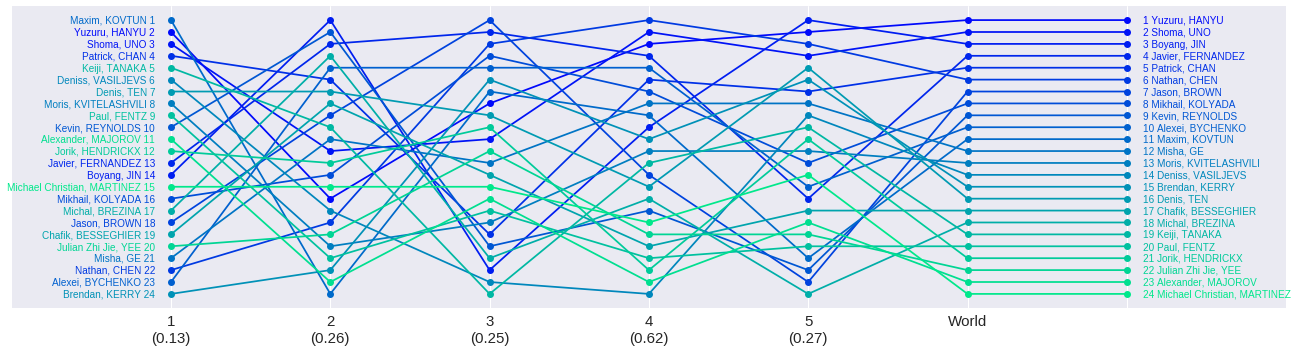

In [926]:
skater_rankings_by_factor.append(world_ranking)
ranking_labels = [str(factor) + '\n' + f'({tau:.2f})' for factor, tau in zip(list(range(1, n_factors+1)), taus_by_factor)] + ['World']

fig, ax = plt.subplots(figsize=(18, 5))
plot_multiple_rankings(fig, ax, skater_rankings_by_factor, ranking_labels,
                       filepath='viz/rank_each_factor.png', xfontsize=15, zorder=None)

# Combine latent scores using logistic regression

In [931]:
# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 

In [932]:
# Initialize baseline, event, and skater scores (random number between 0 and 1 given some seed)
n_factors = 2
random_state = np.random.RandomState(seed=42)
baseline = random_state.random_sample()
skater_scores = random_state.random_sample((len(skater_names), n_factors))
event_scores = random_state.random_sample((n_factors, len(event_names)))

In [933]:
alpha = 0.0005
for i in range(1000):
    # 2a. Calculate gradients
    predicted_scores = skater_scores @ event_scores + baseline
    residuals = predicted_scores - true_scores
    
    baseline_gradient = np.nansum(residuals)
    event_gradients = np.nansum(residuals[:, np.newaxis, :] * skater_scores[:, :, np.newaxis], axis=0)
    skater_gradients = np.nansum(residuals[:, np.newaxis, :] * event_scores[np.newaxis, :, :], axis=2)
    
    # 2b. Update latent scores using gradients
    baseline = baseline - alpha * baseline_gradient
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    
    if i in [998, 999]:

        print(i, np.sqrt(np.nanmean(residuals**2)))

998 0.002070682021509688
999 0.002047425469550496


In [940]:
skater_scores = pd.DataFrame(skater_scores, index=skater_names)

In [941]:
skater_scores_normed = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)

In [943]:
world_ranking = ['Javier, FERNANDEZ', 'Takahito, MURA', 'Misha, GE', 'Alexander, MAJOROV']
skater_scores_normed = skater_scores_normed.reindex(world_ranking)

In [972]:
X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores_normed.values, 2)))
y = np.ones(len(X))

In [979]:
beta = np.full(X.shape[1], 0.5)
alpha = 0.001
n_iter = 1000000
for i in range(n_iter):
    prob = 1 / (1 + np.exp(-X @ beta))
    gradient = (y - prob) @ X
    beta = beta + alpha * gradient
    
    if i in [n_iter-2, n_iter-1]:
        log_likelihood = y @ np.log(prob) + (1 - y) @ np.log(1 - prob)
        print(f'i: {i}, avg ll: {log_likelihood/len(X)}')
    
beta

i: 999998, avg ll: -0.0003197249562632603
i: 999999, avg ll: -0.0003197246410460951


array([9.36245882, 3.3958688 ])

In [1035]:
def log_gradient_ascent(pair_diffs, alpha=0.001, n_iter=1000):
    beta = np.full(pair_diffs.shape[1], 0.5)
    y = np.ones(pair_diffs.shape[0])
    
    for i in range(n_iter):
        prob = 1 / (1 + np.exp(-pair_diffs @ beta))
        gradient = (y - prob) @ pair_diffs
        beta = beta + alpha * gradient

        if i in [n_iter-2, n_iter-1]:
            log_likelihood = y @ np.log(prob)
            print(f'i: {i}, avg ll: {log_likelihood/len(X)}')

    return beta

In [982]:
pair_diffs = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores_normed.values, 2)))
log_gradient_ascent(pair_diffs, n_iter=1000000)

i: 999998, avg ll: -0.0003197249562632603
i: 999999, avg ll: -0.0003197246410460951


array([9.36245882, 3.3958688 ])

Try for 2017 male skaters

In [1108]:
n_factors = 50
baseline, event_scores, skater_scores, rmse = batch_gd_multi(season_scores, 
skater_order=example_skater_order, alpha=0.0005, n_iter=1000, n_factors=n_factors, return_rmse=True)

Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.94e-08


In [1109]:
skater_scores_normed = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
skater_scores_normed = skater_scores_normed.reindex(world_scores.index)

In [1110]:
pair_diffs = np.array(list(skater_scoreA - skater_scoreB for skater_scoreA, skater_scoreB in combinations(skater_scores_normed.values, 2)))
pair_diffs.shape

(276, 50)

In [1111]:
beta = log_gradient_ascent(pair_diffs, n_iter=1000)
beta

i: 998, avg ll: -1.1464787825683533
i: 999, avg ll: -1.1458457194493974


array([-0.18779384,  0.99259319,  0.03618323, -0.93053827,  0.37342599,
       -0.53888311, -0.21568099,  1.1529692 , -1.2684653 ,  0.42918575,
        1.17784386,  0.85949727,  0.36246479,  0.95028158,  0.1105937 ,
        1.16498733, -0.03925011,  1.17300543,  1.09847274,  1.4615729 ,
       -0.35657981,  0.29162744,  1.87643842,  0.30170216,  1.91367562,
        1.4273554 ,  0.79314698,  1.06743949, -0.47079355,  0.71739559,
        0.78020577,  1.09436645,  1.3311269 ,  1.34653724,  1.2283465 ,
        0.50485397, -0.269425  , -0.54664888,  0.96809056,  0.95300336,
       -0.06705332,  0.13852172, -0.28888538, -0.01319205, -0.24595546,
        0.52667722,  0.63686175, -0.05390533, -0.35782474,  0.06948645])

In [1112]:
((pair_diffs @ beta) > 0).sum()

276